In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Merged_Wheat_Features.xlsx to Merged_Wheat_Features.xlsx


In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
merged_df = pd.read_excel("Merged_Wheat_Features.xlsx")

# Step 1: Convert year to numeric for sorting
merged_df['year_numeric'] = merged_df['year'].str[:4].astype(int)

# Step 2: Drop districts with no wheat area ever
active_districts = merged_df.groupby('district')['area_acres'].sum()
active_districts = active_districts[active_districts > 0].index
merged_df = merged_df[merged_df['district'].isin(active_districts)].copy()

# Step 3: Sort by district and year
merged_df = merged_df.sort_values(by=['district', 'year_numeric']).reset_index(drop=True)

# Step 4: Create productivity column
merged_df['productivity'] = merged_df['production_m_ton'] / merged_df['area_acres']
merged_df['productivity'] = merged_df['productivity'].replace([np.inf, -np.inf], np.nan)

# Step 5: Create lagged_area_production (rolling mean of previous 2 years' area_acres)
merged_df['lagged_area_production'] = (
    merged_df.groupby('district')['area_acres']
    .shift(1)
    .rolling(window=2)
    .mean()
    .reset_index(level=0, drop=True)
)

# Step 6: Fill missing lagged_area_production with district mean
merged_df['lagged_area_production'] = merged_df.groupby('district')['lagged_area_production'].transform(
    lambda x: x.fillna(x.mean())
)

# Step 7: Drop helper column (optional)
merged_df.drop(columns='year_numeric', inplace=True)

# Step 1: Sort first by year, then by district name
merged_df = merged_df.sort_values(by=['year', 'districtname']).reset_index(drop=True)



# Step 3: Optional — preview updated structure
merged_df.head(20)


,sl_x,year,districtname,crop,area_acres,area_hectors,yield_rate_acres_maund,yeild_rate_hectors_m_ton,production_m_ton,district_matched,sl_y,district,rainfall,temp,evi,solarrad,productivity,lagged_area_production
0,0,2014-15,Bagerhat,Wheat,729.0,295.0,29.75,2.744,810.0,Bagerhat,34,Bagerhat,80.63,24.52,0.38,15910509.39,1.111111,692.0625
1,2,2014-15,Barguna,Wheat,47.0,19.0,14.30,1.319,25.0,Barguna,10,Barguna,92.22,26.45,0.43,15188590.91,0.531915,2.9375
2,3,2014-15,Barisal,Wheat,3498.0,1416.0,23.93,2.207,3125.0,Barisal,0,Barisal,79.91,25.20,0.39,14789727.70,0.893368,1768.2500
3,4,2014-15,Bhola,Wheat,8354.0,3381.0,31.91,2.943,9951.0,Bhola,1,Bhola,82.81,25.33,0.33,10255863.44,1.191166,6674.5625
4,5,2014-15,Bogura,Wheat,4588.0,1857.0,26.42,2.437,4525.0,Bogra,48,Bogra,53.33,25.52,0.44,16086875.54,0.986269,6016.0000
5,6,2014-15,Brahmanbaria,Wheat,4463.0,1806.0,22.74,2.098,3788.0,Brahamanbaria,12,Brahamanbaria,80.68,26.54,0.47,15674058.62,0.848756,2659.8750
6,7,2014-15,Chandpur,Wheat,2713.0,1098.0,29.22,2.695,2959.0,Chandpur,13,Chandpur,63.09,25.40,0.37,14815387.52,1.090675,1032.8750
7,9,2014-15,Chittagong,Wheat,10.0,4.0,12.18,1.123,5.0,Chittagong,5,Chittagong,70.23,27.64,0.46,15503185.42,0.500000,9.3750
8,10,2014-15,Chuadanga,Wheat,16677.0,6749.0,35.99,3.320,22404.0,Chuadanga,35,Chuadanga,78.43,25.96,0.42,16164748.84,1.343407,5329.4375
9,12,2014-15,Comilla,Wheat,3433.0,1389.0,23.96,2.210,3070.0,Comilla,14,Comilla,64.35,26.45,0.43,15990731.63,0.894262,2531.1250


In [ ]:
# Step 1: Define the correct feature and target columns
feature_cols = ['rainfall', 'temp', 'evi','solarrad','productivity','lagged_area_production']
target_col = 'production_m_ton'

# Step 2: Ensure the target column is numeric
merged_df[target_col] = pd.to_numeric(merged_df[target_col], errors='coerce').fillna(0)

# Step 3: Ensure area_acres is numeric (if needed)
merged_df['area_acres'] = pd.to_numeric(merged_df['area_acres'], errors='coerce')

# Step 4: Add binary flag for wheat-producing districts
merged_df['Grows_Wheat'] = (merged_df[target_col] > 0).astype(int)

# Step 5: Extract features (X) and target (y)
X = merged_df[feature_cols]
y = merged_df[target_col]

# Step 6: Confirm structure
print("Feature matrix X shape:", X.shape)
print("Target vector y shape:", y.shape)
print("\nFeatures (X):\n", X.head())
print("\nTarget (y):\n", y.head())
print("\nGrows_Wheat Flag:\n", merged_df['Grows_Wheat'].astype(int).head())



Feature matrix X shape: (610, 6)
Target vector y shape: (610,)

Features (X):
    rainfall  temp  evi    solarrad  productivity  lagged_area_production
0     80.63 24.52 0.38 15910509.39          1.11                  692.06
1     92.22 26.45 0.43 15188590.91          0.53                    2.94
2     79.91 25.20 0.39 14789727.70          0.89                 1768.25
3     82.81 25.33 0.33 10255863.44          1.19                 6674.56
4     53.33 25.52 0.44 16086875.54          0.99                 6016.00

Target (y):
 0    810.00
1     25.00
2   3125.00
3   9951.00
4   4525.00
Name: production_m_ton, dtype: float64

Grows_Wheat Flag:
 0    1
1    1
2    1
3    1
4    1
Name: Grows_Wheat, dtype: int64


In [ ]:
# Install lazypredict and sklearn
!pip install lazypredict scikit-learn --quiet

In [ ]:
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor

# Step 1: Filter rows with production
filtered_df = merged_df[merged_df['production_m_ton'] >= 30].copy()

# Step 2: Define features and target
feature_cols = ['rainfall', 'temp', 'evi','solarrad','productivity','lagged_area_production']
target_col = 'production_m_ton'

# Step 3: Clean target column and align features
y = pd.to_numeric(filtered_df[target_col], errors='coerce').replace([np.inf, -np.inf, np.nan], np.nan).dropna()
X = filtered_df.loc[y.index, feature_cols]

# Step 4: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Step 5: Run LazyPredict to compare regressors
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Step 6: Display all models' performance
pd.set_option('display.max_rows', None)
display(models)


  0%|          | 0/42 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 469, number of used features: 6
[LightGBM] [Info] Start training from score 19957.517890
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.96,0.96,8414.03,0.63
XGBRegressor,0.96,0.96,8462.57,0.36
RandomForestRegressor,0.95,0.96,8851.53,0.66
GradientBoostingRegressor,0.95,0.96,8876.89,0.47
BaggingRegressor,0.95,0.95,9205.30,0.09
OrthogonalMatchingPursuitCV,0.95,0.95,9277.30,0.05
SGDRegressor,0.95,0.95,9296.08,0.05
LassoLarsIC,0.95,0.95,9306.38,0.06
LassoLars,0.95,0.95,9307.81,0.04


In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# Step 1: Define features and target
feature_cols = ['rainfall', 'temp', 'evi', 'solarrad', 'productivity', 'lagged_area_production']
target_col = 'production_m_ton'

# Step 2: Clean and align data
filtered_df[target_col] = pd.to_numeric(filtered_df[target_col], errors='coerce')
filtered_df['area_acres'] = pd.to_numeric(filtered_df['area_acres'], errors='coerce')
filtered_df = filtered_df.dropna(subset=feature_cols + [target_col])

y = filtered_df[target_col].astype(float)
X = filtered_df[feature_cols]

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train XGB Regressor
model = XGBRegressor(
    max_depth=3,
    learning_rate=0.03,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=2,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
model.fit(X_train, y_train)

# Step 5: Evaluate model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f} metric tons")

# Step 6: Predict on full dataset
all_predictions = model.predict(X)
filtered_df['predicted_production_m_ton'] = all_predictions

# Step 7: Preview results with serial number
preview_df = filtered_df[['year', 'district', 'production_m_ton', 'predicted_production_m_ton']].copy()
preview_df = preview_df.reset_index(drop=True)
preview_df.insert(0, 'sl_no', preview_df.index + 1)

print(preview_df.head(10))


R² Score: 0.9512
MAE: 5108.49 metric tons
   sl_no     year       district  production_m_ton  predicted_production_m_ton
0      1  2014-15       Bagerhat            810.00                     2085.96
1      2  2014-15        Barisal           3125.00                     1647.28
2      3  2014-15          Bhola           9951.00                    10134.17
3      4  2014-15          Bogra           4525.00                     5631.11
4      5  2014-15  Brahamanbaria           3788.00                     2329.76
5      6  2014-15       Chandpur           2959.00                     2325.19
6      7  2014-15      Chuadanga          22404.00                    19825.00
7      8  2014-15        Comilla           3070.00                     3459.87
8      9  2014-15          Dhaka            716.00                     1187.19
9     10  2014-15       Dinajpur          66399.00                    43430.47


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error



In [ ]:
# Core metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # √MSE = RMSE

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print results
print(f"R² Score       : {r2:.4f}")
print(f"MAE            : {mae:.2f} metric tons")
print(f"RMSE           : {rmse:.2f} metric tons")
print(f"MAPE           : {mape:.2f}%")


R² Score       : 0.9512
MAE            : 5108.49 metric tons
RMSE           : 9581.86 metric tons
MAPE           : 345.12%


In [ ]:
# Step 9: Predict on full dataset
filtered_df['predicted_production_m_ton'] = model.predict(X)

# Step 10: Compute residuals and absolute residuals
filtered_df['residual'] = filtered_df['production_m_ton'] - filtered_df['predicted_production_m_ton']
filtered_df['abs_residual'] = filtered_df['residual'].abs()

# Step 11: Set threshold for top 7% highest residuals
threshold = filtered_df['abs_residual'].quantile(0.93)

# Step 12: Extract outliers above threshold
outliers_df = filtered_df[filtered_df['abs_residual'] > threshold].copy()

# Step 13: Sort by absolute residual (descending)
outliers_df = outliers_df.sort_values(by='abs_residual', ascending=False)

# Step 14: Preview selected columns
outlier_preview = outliers_df[['year', 'district', 'production_m_ton',
                               'predicted_production_m_ton', 'residual', 'abs_residual']]

# Step 15: Show results
print("\nTop 7% outliers (based on residuals):")
print(outlier_preview.head(50))



Top 7% outliers (based on residuals):
        year    district  production_m_ton  predicted_production_m_ton  \
182  2016-17  Thakurgaon         226821.00                   169484.27   
243  2017-18  Thakurgaon         196885.00                   162718.58   
159  2016-17     Naogaon          92199.00                    65665.86   
121  2015-16  Thakurgaon         199834.00                   173839.09   
11   2014-15    Dinajpur          66399.00                    43430.47   
72   2015-16    Dinajpur          71967.00                    49083.75   
291  2018-19  Panchagarh          54391.00                    76189.01   
95   2015-16    Meherpur          45383.00                    24433.13   
217  2017-18    Meherpur          23902.00                    44345.93   
143  2016-17   Jhenaidah           9380.00                    29072.89   
591  2023-24   Nawabganj         113239.00                    93957.04   
60   2014-15  Thakurgaon         187325.00                   168069.48   

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

# Step 1: Clean 'year' column
merged_df['year'] = merged_df['year'].astype(str).str.strip()

# Step 2: Filter for production >= 30 MT
filtered_df = merged_df[merged_df['production_m_ton'] >= 30].copy()

# Step 3: Define features and target
feature_cols = ['rainfall', 'temp', 'evi', 'solarrad', 'productivity', 'lagged_area_production']
target_col = 'production_m_ton'

# Step 4: Ensure features and target are numeric
filtered_df[feature_cols] = filtered_df[feature_cols].apply(pd.to_numeric, errors='coerce')
filtered_df[target_col] = pd.to_numeric(filtered_df[target_col], errors='coerce')
filtered_df = filtered_df.dropna(subset=feature_cols + [target_col])

# Step 5: Extract X and y
X = filtered_df[feature_cols]
y = filtered_df[target_col]

# Step 6: Define XGBoost model
model = XGBRegressor(
    max_depth=2,
    learning_rate=0.02,
    n_estimators=180,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=2,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Step 7: Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Step 8: R² cross-validation
cv_r2 = cross_val_score(model, X, y, cv=kf, scoring='r2')
print("R² Scores:", np.round(cv_r2, 4))
print("Mean R²:", np.mean(cv_r2).round(4))

# Step 9: MAE cross-validation
cv_mae = cross_val_score(model, X, y, cv=kf, scoring=make_scorer(mean_absolute_error))
print("\nMAE Scores:", np.round(cv_mae, 2))
print("Mean MAE:", np.mean(cv_mae).round(2), "metric tons")

# Step 10: RMSE cross-validation
rmse_scorer = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False))
cv_rmse = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
print("\nRMSE Scores:", np.round(cv_rmse, 2))
print("Mean RMSE:", np.mean(cv_rmse).round(2), "metric tons")


R² Scores: [0.9165 0.8653 0.9427 0.9163 0.9543]
Mean R²: 0.919

MAE Scores: [6424.3  6297.69 4908.12 4953.5  4367.08]
Mean MAE: 5390.14 metric tons

RMSE Scores: [nan nan nan nan nan]
Mean RMSE: nan metric tons


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

# Step 1: Filter rows with production >= 30
filtered_df = merged_df[merged_df['production_m_ton'] >= 30].copy()



# Step 2: Define features and target
feature_cols = ['rainfall', 'temp', 'evi', 'solarrad','productivity','lagged_area_production']
target_col = 'production_m_ton'

# Step 3: Clean and align data
filtered_df[feature_cols] = filtered_df[feature_cols].apply(pd.to_numeric, errors='coerce')
filtered_df[target_col] = pd.to_numeric(filtered_df[target_col], errors='coerce')
filtered_df = filtered_df.dropna(subset=feature_cols + [target_col])

y = filtered_df[target_col].astype(float)
X = filtered_df[feature_cols]

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Step 5: Train XGBoost Regressor
model = XGBRegressor(

)
model.fit(X_train, y_train)

# Step 6: Evaluate model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f} metric tons")

# Step 7: Predict on full filtered dataset
all_predictions = model.predict(X)
filtered_df['predicted_production_m_ton'] = all_predictions

# Step 8: Preview results with serial number
preview_df = filtered_df[['year', 'district', 'production_m_ton', 'predicted_production_m_ton']].copy()
preview_df = preview_df.reset_index(drop=True)
preview_df.insert(0, 'sl_no', preview_df.index + 1)

print(preview_df.head(10))


R² Score: 0.9599
MAE: 4492.90 metric tons
   sl_no     year       district  production_m_ton  predicted_production_m_ton
0      1  2014-15       Bagerhat            810.00                     2618.91
1      2  2014-15        Barisal           3125.00                     3124.70
2      3  2014-15          Bhola           9951.00                    12030.89
3      4  2014-15          Bogra           4525.00                     4479.64
4      5  2014-15  Brahamanbaria           3788.00                     3757.47
5      6  2014-15       Chandpur           2959.00                     2958.58
6      7  2014-15      Chuadanga          22404.00                    10001.87
7      8  2014-15        Comilla           3070.00                     3075.85
8      9  2014-15          Dhaka            716.00                      752.94
9     10  2014-15       Dinajpur          66399.00                    54173.34


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor
import pandas as pd

# Step 1: Filter rows with production >= 30
filtered_df = merged_df[merged_df['production_m_ton'] >= 30].copy()



# Step 3: Define features and target
feature_cols = ['rainfall', 'temp', 'evi', 'solarrad','productivity','lagged_area_production']
target_col = 'production_m_ton'

# Step 4: Clean and drop NA
filtered_df[feature_cols] = filtered_df[feature_cols].apply(pd.to_numeric, errors='coerce')
filtered_df[target_col] = pd.to_numeric(filtered_df[target_col], errors='coerce')
filtered_df = filtered_df.dropna(subset=feature_cols + [target_col])

# Step 5: Split into training (≤2022–23) and testing (2023–24)
train_df = filtered_df[filtered_df['year'] <= '2022-23'].copy()
test_df = filtered_df[filtered_df['year'] == '2023-24'].copy()

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

# Step 6: Train XGBoost Regressor
model = XGBRegressor(
    max_depth=2,
    learning_rate=0.04,
    n_estimators=200,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_alpha=2,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
model.fit(X_train, y_train)

# Step 7: Evaluate on 2023–24 test set
y_test_pred = model.predict(X_test)
r2 = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
print(f"Test R² Score (2023–24): {r2:.4f}")
print(f"Test MAE (2023–24): {mae:.2f} metric tons")

# Step 8: Predict on entire filtered dataset
filtered_df['predicted_production_m_ton'] = model.predict(filtered_df[feature_cols])

# Step 9: Preview top predictions
preview_df = filtered_df[['year', 'district', 'production_m_ton', 'predicted_production_m_ton']].copy()
preview_df = preview_df.reset_index(drop=True)
preview_df.insert(0, 'sl_no', preview_df.index + 1)

print(preview_df.head())


Test R² Score (2023–24): 0.8936
Test MAE (2023–24): 6103.72 metric tons
   sl_no     year       district  production_m_ton  predicted_production_m_ton
0      1  2014-15       Bagerhat            810.00                     2137.51
1      2  2014-15        Barisal           3125.00                     1574.12
2      3  2014-15          Bhola           9951.00                     9693.29
3      4  2014-15          Bogra           4525.00                     6933.95
4      5  2014-15  Brahamanbaria           3788.00                     2058.18


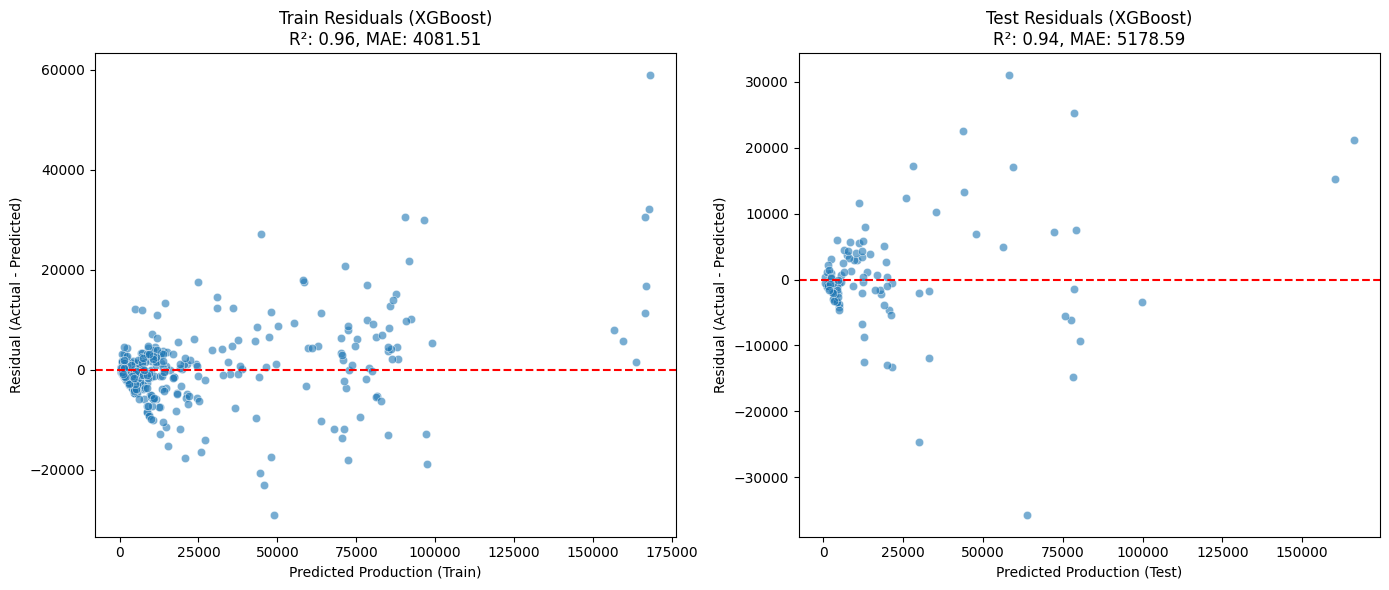

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

# Step 1: Filter for valid production records (> 30 metric tons)
filtered_df = merged_df[merged_df['production_m_ton'] > 30].copy()


# Step 2: Define feature columns (include area_acres) and target
feature_cols = ['rainfall', 'temp', 'evi', 'solarrad','productivity','lagged_area_production']
target_col = 'production_m_ton'

# Step 3: Clean and align data
filtered_df[feature_cols] = filtered_df[feature_cols].apply(pd.to_numeric, errors='coerce')
filtered_df[target_col] = pd.to_numeric(filtered_df[target_col], errors='coerce')
filtered_df = filtered_df.dropna(subset=feature_cols + [target_col])

X = filtered_df[feature_cols]
y = filtered_df[target_col]

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Step 5: Train XGB Regressor (general setup)
model = XGBRegressor(max_depth=2,
    learning_rate=0.02,
    n_estimators=200,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_alpha=2,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1,
    verbosity=0

)
model.fit(X_train, y_train)

# Step 6: Predict and residuals
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Step 7: Metrics
r2_train = r2_score(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Step 8: Plot residuals
plt.figure(figsize=(14, 6))

# Train plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train_pred, y=train_residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Train Residuals (XGBoost)\nR²: {r2_train:.2f}, MAE: {mae_train:.2f}")
plt.xlabel("Predicted Production (Train)")
plt.ylabel("Residual (Actual - Predicted)")

# Test plot
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test_pred, y=test_residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Test Residuals (XGBoost)\nR²: {r2_test:.2f}, MAE: {mae_test:.2f}")
plt.xlabel("Predicted Production (Test)")
plt.ylabel("Residual (Actual - Predicted)")

plt.tight_layout()
plt.show()


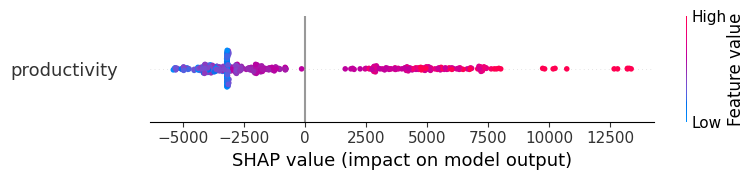

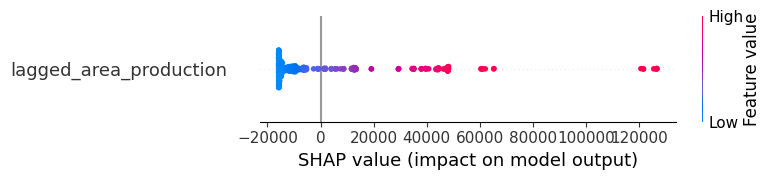

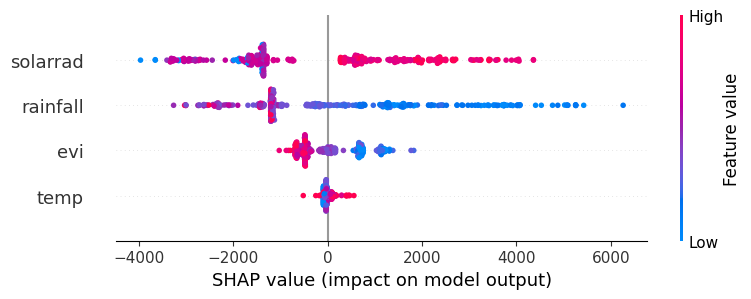

In [ ]:
import shap

# Step 1: Create SHAP explainer and compute SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# --------------------
# Plot 1: SHAP values for 'productivity' only
# --------------------
X_prod = X_train[['productivity']]
shap_values_prod = shap.Explanation(
    values=shap_values.values[:, X_train.columns.get_loc('productivity')].reshape(-1, 1),
    base_values=shap_values.base_values,
    data=X_prod.values,
    feature_names=['productivity']
)
shap.summary_plot(shap_values_prod, X_prod, plot_type="dot")

# --------------------
# Plot 2: SHAP values for 'lagged_area_production' only
# --------------------
X_lag = X_train[['lagged_area_production']]
shap_values_lag = shap.Explanation(
    values=shap_values.values[:, X_train.columns.get_loc('lagged_area_production')].reshape(-1, 1),
    base_values=shap_values.base_values,
    data=X_lag.values,
    feature_names=['lagged_area_production']
)
shap.summary_plot(shap_values_lag, X_lag, plot_type="dot")

# --------------------
# Plot 3: SHAP values for remaining 4 features
# --------------------
cols_remaining = ['rainfall', 'temp', 'evi', 'solarrad']
X_remain = X_train[cols_remaining]
col_indices = [X_train.columns.get_loc(c) for c in cols_remaining]

shap_values_remain = shap.Explanation(
    values=shap_values.values[:, col_indices],
    base_values=shap_values.base_values,
    data=X_remain.values,
    feature_names=cols_remaining
)
shap.summary_plot(shap_values_remain, X_remain, plot_type="dot")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error
from xgboost import XGBRegressor



# Step 2: Filter for production >= 30 MT
filtered_df = filtered_df[filtered_df['production_m_ton'] >= 30].copy()

# Step 3: Define features and target
feature_cols = ['rainfall', 'temp', 'evi', 'solarrad','productivity','lagged_area_production']
target_col = 'production_m_ton'

# Step 4: Clean and drop NA
filtered_df[feature_cols] = filtered_df[feature_cols].apply(pd.to_numeric, errors='coerce')
filtered_df[target_col] = pd.to_numeric(filtered_df[target_col], errors='coerce')
filtered_df = filtered_df.dropna(subset=feature_cols + [target_col])

X = filtered_df[feature_cols]
y = filtered_df[target_col]

# Step 5: Define XGB Regressor (aligned with your main spec)
model = XGBRegressor(
    max_depth=2,
    learning_rate=0.02,
    n_estimators=200,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_alpha=2,
    reg_lambda=2,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Step 6: Set up K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Step 7: R² cross-validation
cv_r2 = cross_val_score(model, X, y, cv=kf, scoring='r2')
print("R² Scores:", cv_r2)
print("Mean R²:", np.mean(cv_r2).round(4))

# Step 8: MAE cross-validation
mae_scorer = make_scorer(mean_absolute_error)
cv_mae = cross_val_score(model, X, y, cv=kf, scoring=mae_scorer)
print("\nMAE Scores:", cv_mae)
print("Mean MAE:", np.mean(cv_mae).round(2), "metric tons")


R² Scores: [0.93572384 0.88985446 0.94161646 0.92459873 0.93676119]
Mean R²: 0.9257

MAE Scores: [5324.49595298 5132.62514482 5542.30022722 4476.71453802 5317.32705189]
Mean MAE: 5158.69 metric tons


In [ ]:
# ✅ Predict on full dataset
filtered_df['predicted_production_m_ton'] = model.predict(X)

# ✅ Compute residuals and absolute residuals
filtered_df['residual'] = filtered_df['production_m_ton'] - filtered_df['predicted_production_m_ton']
filtered_df['abs_residual'] = filtered_df['residual'].abs()

# ✅ Set threshold for top 7% highest residuals (93rd percentile)
threshold = filtered_df['abs_residual'].quantile(0.93)

# ✅ Extract outliers
outliers_df = filtered_df[filtered_df['abs_residual'] > threshold].copy()

# ✅ Sort and preview
outliers_df = outliers_df.sort_values(by='abs_residual', ascending=False)
outlier_preview = outliers_df[['year', 'district', 'production_m_ton',
                               'predicted_production_m_ton', 'residual', 'abs_residual']]

# ✅ Show top results
print("\nTop 7% outliers (based on residuals):")
print(outlier_preview.head(50))



Top 7% outliers (based on residuals):
        year    district  production_m_ton  predicted_production_m_ton  \
182  2016-17  Thakurgaon         226821.00                   167919.94   
194  2017-18    Dinajpur          27949.00                    63662.97   
121  2015-16  Thakurgaon         199834.00                   167760.92   
169  2016-17  Panchagarh          89304.00                    58269.28   
107  2015-16       Pabna         121058.00                    90470.51   
243  2017-18  Thakurgaon         196885.00                   166415.97   
46   2014-15       Pabna         126403.00                    96393.61   
156  2016-17    Meherpur          19893.00                    48920.69   
72   2015-16    Dinajpur          71967.00                    44749.00   
12   2014-15    Faridpur         103773.00                    78557.60   
576  2023-24     Kushtia           5318.00                    29967.85   
149  2016-17     Kushtia          22671.00                    45699.75   